In [2]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [3]:
%cd /content/drive/Shareddrives/FP/FP/Captioning/

/content/drive/Shareddrives/FP/FP/Captioning


In [ ]:
#!pip uninstall torch
#!pip install torch torchvision  --index-url https://download.pytorch.org/whl/cu121
!pip  install -r grit/requirements.txt
!python -m spacy download en
!python grit/models/ops/setup.py build develop

In [ ]:
from cap import Caption, FaceRecognition

In [4]:
from PIL import Image

In [5]:
list_of_lang = 'https://gtts.readthedocs.io/en/v2.2.0/_modules/gtts/lang.html'
from gtts import gTTS
from IPython.display import Audio
from googletrans import Translator

In [6]:
def convert_to_mp3(text,lang, filename):
  tts = gTTS(text=text,
             lang=lang)
  tts.save(gDrive + filename)
  Audio(gDrive + filename)
def translate_and_convert(text, target_language, filename):
    translator = Translator()
    translation = translator.translate(text, dest=target_language)
    convert_to_mp3(translation.text,target_language, filename)
    return translation.text

In [7]:
import cv2
import uuid
import pickle
import pandas as pd
import matplotlib.pyplot as plt

from PIL import Image
from pathlib import Path
from deepface import DeepFace

from lib.config import config
from lib.face_database import FaceDatabase
from lib.face_recognition import FaceRecognition

23-12-19 20:16:20 - Directory /root/.deepface created
23-12-19 20:16:20 - Directory /root/.deepface/weights created


In [8]:
face_database = FaceDatabase(**config.face_database)
face_recognition = FaceRecognition(**config.face_recognition)

## 1. Obtaining face images with labels

In [ ]:
# 1. Get image (possibly with no or multiple faces)
im = cv2.imread('/content/drive/Shareddrives/FP/FP/Captioning/images/kuo7.jpg')

# 2. Detect faces
detected = face_recognition.get_faces(im)

# 3. For each face in the image, query label
labels = []
for it, individual in enumerate(detected):
    plt.figure(it, [5, 5]); plt.imshow(individual['face']); plt.axis('off')
    labels.append(input())

## 2. Inserting face images and labels into database

In [52]:
for individual, label in zip(detected, labels):
    face_database.store(individual['face'], label)
    individual['face'] = cv2.resize(individual['face'], (224,224))

## 3. Searching a match for new faces

23-12-19 19:20:13 - ⚠️ Representations for images in ./database/ folder were previously stored in representations_vgg_face.pkl. If you added new instances after the creation, then please delete this file and call find function again. It will create it again.
23-12-19 19:20:13 - There are 8 representations found in representations_vgg_face.pkl
23-12-19 19:20:13 - find function lasts 0.16252446174621582 seconds
Detected: Bill (at position (405, 73))


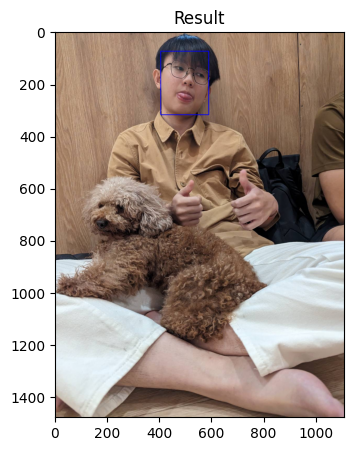

In [111]:
# 1. Get query image (possibly with no or multiple faces)
query = cv2.imread('/content/drive/Shareddrives/FP/FP/Captioning/images/0012.jpg').astype('uint8')

# 2. Find matches for each face
detected = face_recognition.find_faces(query, face_database)

# 3. Show matches
query = cv2.cvtColor(query, cv2.COLOR_BGR2RGB)
labels = []
for label, bounding_box in detected:
    x, y, w, h = bounding_box
    cv2.rectangle(query, (x, y), (x+w, y+h), (0,0,255), 2)
    print(f'Detected: {label} (at position ({x}, {y}))')
    labels.append(label)
plt.figure(1, [5, 5]); plt.title('Result'); plt.imshow(query)

## 4. Captioning

In [112]:
!python grit/inference_caption.py \
        +img_path='/content/drive/Shareddrives/FP/FP/Captioning/images/0012.jpg' \
        +vocab_path='/content/drive/Shareddrives/FP/FP/Captioning/grit/data/vocab.json' \
        exp.checkpoint='/content/drive/Shareddrives/FP/FP/Captioning/grit/grit_checkpoint_4ds.pth'

#img = Image.open('/content/drive/Shareddrives/FP/FP/Captioning/images/0001.jpg').convert('RGB')
#img

/usr/local/lib/python3.10/dist-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3526.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]
model missing:0 model unexpected:6
a boy sitting on a bed with a dog and


In [113]:
with open('/content/drive/Shareddrives/FP/FP/Captioning/outputs/output.txt', 'r') as file:
    # Read the entire content of the file
      content = file.read()
content

'a boy sitting on a bed with a dog and'

## 5. Nouns -> Name -> TTS


In [114]:
# Define a list of old words to find

# Define a list of old words to find
gDrive = '/content/drive/Shareddrives/FP/FP/tts'
keywords = ['a man', 'a woman', 'a person', 'a boy', 'a girl', 'a young man', 'a young woman', 'a young boy', 'a young girl']
new_word = labels
print(new_word)

# Loop through the list of old words and perform replacements
i = 0
for old_word in keywords:
    try:
        if content.find(old_word) != -1 and new_word[i]!='Unknown':  # Check if old_word is found in content
            content = content.replace(old_word, new_word[i])
            i += 1
    except Exception as e:
        print("Error:", e)
        continue


# Print the modified content
print(content)
translated_text = translate_and_convert(content,'id','output.mp3')
print(translated_text)
Audio(gDrive + 'output.mp3')



['Bill']
Bill sitting on a bed with a dog and
Tagihan duduk di tempat tidur dengan seekor anjing dan
